# First steps

In [394]:
#importing
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import nltk
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, f_regression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, ExtraTreesClassifier
from sklearn.feature_selection import chi2
from sklearn.svm import SVC, LinearSVC
from tqdm import tqdm_notebook
from pathlib import Path
words_english = set(nltk.corpus.words.words())
correct_words_set = set(nltk.corpus.brown.words())
lematizator = en_core_web_sm.load()
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [395]:
# downloading the data
RANDOM_STATE = 47
essays = pd.read_excel('training_set_rel3.xlsx')
essays = essays[['essay_set','essay', 'domain1_score']].dropna()

In [396]:
essays.head()

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8.0
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9.0
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7.0
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10.0
4,1,"Dear @LOCATION1, I know having computers has a...",8.0


In [397]:
print(essays.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12977 entries, 0 to 12977
Data columns (total 3 columns):
essay_set        12977 non-null int64
essay            12977 non-null object
domain1_score    12977 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 405.5+ KB
None


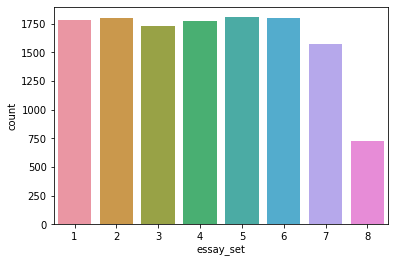

In [398]:
#Topics distribution
sns.countplot(essays['essay_set'])

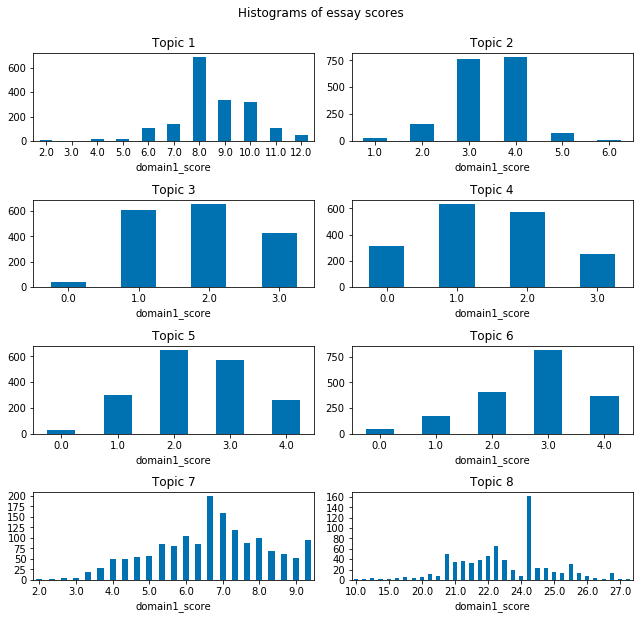

In [399]:
#Scors distribution in each topic
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        essays[essays['essay_set'] == topic_number]\
            .groupby('domain1_score')['essay_set'].agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Feature Engineering

In [400]:
#List of all parts of speech
list_of_all_tags=['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']

In [401]:
# Choosing essay topic, reseting indexes and lowering all words
essays = essays[(essays['essay_set']==4)]
essays['essay'] = essays['essay'].apply(lambda x : x.lower())
essays.reset_index(drop=True,inplace=True)

In [402]:
#Splitting essays by sentences and counting them
nltk_sentences_tokinized = []
for i in tqdm_notebook(essays['essay']):
    nltk_sentences_tokinized += [nltk.sent_tokenize(i)]
essays['essay_sentences'] = nltk_sentences_tokinized
essays['sentences_count'] = essays["essay_sentences"].apply(lambda x:len(x))

In [403]:
#Removing punctuation and counting words
nltk_words_tokinized = []
for i in tqdm_notebook(essays['essay']):
    nltk_words_tokinized += [[word for word in nltk.word_tokenize(i) if word not in punctuation]]
essays['essay_words'] = nltk_words_tokinized
essays['words_count'] = essays['essay_words'].apply(lambda x:len(x))

In [404]:
#Counting punctuation, spelling errors, charachters, words per sentence ratio, average sentence length
def words_filter(essays):
    punctuation_count = []
    misspelled_words_count = []
    for essay in tqdm_notebook(essays):
        pc_temp=0
        mw_temp=0
        for word in nltk.word_tokenize(essay):
            if word.lower() not in punctuation:
                if word.lower() not in correct_words_set:
                    mw_temp+=1
            else:
                pc_temp+=1
        punctuation_count.append(pc_temp)
        misspelled_words_count.append(mw_temp)
    return punctuation_count,misspelled_words_count
word_features = words_filter(essays['essay'])
essays['punctuatioon_count'] = word_features[0]
essays['spelling_errors'] = word_features[1]
essays['character_count'] = essays['essay'].apply(lambda essay:len(essay))
essays['words_per_sent_ratio'] = round(essays['words_count']/essays['sentences_count'])
essays['avg_sen_len'] = round(essays['character_count']/essays['sentences_count'])

In [405]:
# Counting only english words
english_words=[]
for listofwords in tqdm_notebook(essays['essay_words']):
    temp_english_word=0
    for word in listofwords:
        if word in words_english:
            temp_english_word+=1
    english_words.append(temp_english_word)
essays['english_words']=english_words

In [406]:
#Counting only non-stopwords and stopwords
nltk_words_tokinized_no_stop_words = []
stopwords_count = []
for tolinized_list in tqdm_notebook(essays['essay_words']):
    temp_stop_words_count = 0
    temp_nsw = []
    for word in tolinized_list:
        if word not in STOP_WORDS:
            temp_nsw.append(word)
        else:
            temp_stop_words_count+=1
    nltk_words_tokinized_no_stop_words.append(temp_nsw)
    stopwords_count.append(temp_stop_words_count)
essays['essay_words'] = nltk_words_tokinized_no_stop_words
essays['stopwords_count'] = stopwords_count

In [407]:
#Joining essay without stopwords
def words_joiner(essays):
    for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
        essays['essay_words'][line_number] = ' '.join(essays['essay_words'][line_number])

In [408]:
#Tagging evry word with the corespondent part of speech
for i in list_of_all_tags:
    essays[i] = 0
for line_number in tqdm_notebook(range(essays.index[0],essays.index[-1]+1)):
    temp_pos_list = np.unique(np.array(nltk.pos_tag(essays['essay_words'][line_number]))[:,1], return_counts=True)
    pos_list = list(zip(temp_pos_list[0],temp_pos_list[1]))
    for i in pos_list:
        essays[i[0]][line_number]=i[1]
essays.drop(columns=["''", '--', ':', '(', ')', '.', ',', '``', '$','essay','essay_sentences'],inplace=True,axis=1)
words_joiner(essays)

In [409]:
#Reducing every word to its grammatical root and counting absolute and unique number of those roots
lemmatized_essay_words = []
for essay in  tqdm_notebook(essays['essay_words']):
    lemmatized = [t.lemma_ for t in lematizator(essay)]
    lemmatized_essay_words.append(lemmatized)
essays['essay_words'] = lemmatized_essay_words
essays['token_count'] = essays['essay_words'].apply(lambda x: len(x))
essays['unique_token_count'] = essays['essay_words'].apply(lambda x: len(set(x)))
words_joiner(essays)

# Modeling

In [410]:
#Vectorization of text data
tv = TfidfVectorizer(ngram_range=(1, 5), max_features=100000)
essay_words_vectorized = tv.fit_transform(essays['essay_words'])
y_train = essays['domain1_score']

In [443]:
#All choosen ML models
lin_reg = LinearRegression(n_jobs=-1,normalize=True)
log_clf = LogisticRegression(C=20,n_jobs=-1,random_state = RANDOM_STATE)
catboost_reg = CatBoostRegressor(n_estimators=1000,random_state = RANDOM_STATE)
svm = LinearSVC(random_state = RANDOM_STATE)
random_forest = RandomForestClassifier(random_state = RANDOM_STATE)
catboost_clf=CatBoostClassifier(n_estimators=1000,random_state = RANDOM_STATE)
NBC=MultinomialNB()

In [412]:
#Numerical features selection

#sel_varience = VarianceThreshold(threshold=(.9 * (1 - .9)))
#selected_sel_varience = sel_varience.fit_transform(essays.drop(['domain1_score','essay_words','essay_set'],axis=1))
sel_k_best = SelectKBest(chi2, k=15)
selected_sel_k_best = sel_k_best.fit_transform(essays.drop(['domain1_score','essay_words','essay_set'],axis=1),y_train)

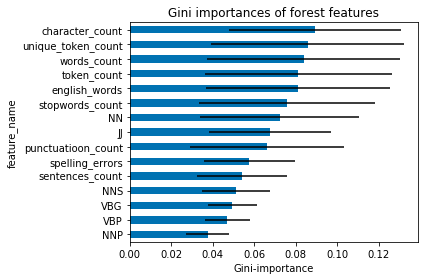

In [413]:
#Feature importances visualization
X = essays[essays.drop(['domain1_score','essay_words','essay_set'],axis=1).columns[(sel_k_best.get_support())]]
y = y_train.astype(np.float64)
forest = ExtraTreesClassifier(n_estimators=250, random_state=26)
forest.fit(X, y)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# plot feature importances
features = pd.DataFrame({'feature_name': X.columns, 'importance': forest.feature_importances_, 'std': std})
features.sort_values('importance').plot.barh(x='feature_name', y='importance', xerr='std', legend=False)
plt.title('Gini importances of forest features')
plt.xlabel('Gini-importance')
plt.tight_layout()
plt.show()

In [415]:
#Performng numerical features scaling, stacking with vectorized text data and dimentionality reduction
pca = TruncatedSVD(n_components=15,random_state = RANDOM_STATE)
scaleer = StandardScaler(copy=True, with_mean=True, with_std=True)
numerical_scaled = scaleer.fit_transform(selected_sel_k_best)
essay_words_vectorized_reduced = pca.fit_transform(essay_words_vectorized)
X_reduced = np.concatenate((essay_words_vectorized_reduced,numerical_scaled),axis=1)
print(X_reduced.shape)

(1771, 30)


In [444]:
#Performing 5 fold cross-validation
model = log_clf
kappa_scorer = make_scorer(cohen_kappa_score)
splits = KFold(n_splits=5,random_state = RANDOM_STATE)
cv_scores_kappa_scorer = cross_val_score(model, X_reduced, y_train, cv=splits, scoring=kappa_scorer, n_jobs=-1, verbose=True)
cv_scores_accuracy = cross_val_score(model, X_reduced, y_train, cv=splits, scoring='accuracy', n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [445]:
#Printing results
print('folds average accuracy score:{},folds average kappa score:{}'.format(cv_scores_accuracy.mean(),cv_scores_kappa_scorer.mean()))
print('accuracy_scores:{}'.format(cv_scores_accuracy))
print('kappa_scores:{}'.format(cv_scores_kappa_scorer))

folds average accuracy score:0.6589559958621788,folds average kappa score:0.5139691578288463
accuracy_scores:[0.64788732 0.65536723 0.66949153 0.65819209 0.66384181]
kappa_scores:[0.49121158 0.5104456  0.51973562 0.52127945 0.52717355]


# Saving the final model

In [446]:
#Training the model on whole data than saving the model
model = LogisticRegression(C=10,n_jobs=-1,random_state = RANDOM_STATE)
model.fit(X_reduced, y_train)
pickle.dump(model,open('model.pkl','wb'))